In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load model
MODEL_PATH= "output/SGDreg_128_256_conv_1024_dout_09_512_dout_07_256_dense/pt_80_10_10_lr_0.01_bs_64_ep_200/model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

2023-11-16 19:34:16.259958: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 19:34:16.380967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 19:34:16.996541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-16 19:34:19.165402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

In [3]:
from src.dataloader import read_train, read_val
X_train, y_train = read_train("input/data/train_80_10_10")
X_val, y_val = read_val("input/data/train_80_10_10")

In [4]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred))

  1/217 [..............................] - ETA: 58s

2023-11-16 19:34:20.010164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-16 19:34:20.114654: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-16 19:34:20.114668: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-16 19:34:20.114701: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-16 19:34:20.161193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


217/217 [==============================] - 1s 2ms/step
0.8554130027389362


In [7]:
import src.config as config
output_shape = len(config.LABELS)
LEARNING_RATE = 0.0001
BATCH_SIZE = 64

layers = [
            keras.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)),
            keras.layers.Conv2D(32,(3,3), activation = 'relu', 
                                kernel_regularizer=keras.regularizers.l2(0.9)),
            keras.layers.MaxPooling2D(pool_size = (2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(64,(3,3), activation = 'relu', 
                                kernel_regularizer=keras.regularizers.l2(0.9)),
            keras.layers.MaxPooling2D(pool_size = (2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(64,(3,3), activation = 'relu', 
                                kernel_regularizer=keras.regularizers.l2(0.9)),
            keras.layers.BatchNormalization(),

            keras.layers.Flatten(),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dropout(0.9),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(output_shape, activation='softmax')
]

model = keras.Sequential(layers)

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
## Train model
from src.preprocessing import CustomDataGenerator

EPOCHS = 200
train_generator = CustomDataGenerator(X_train, y_train, batch_size=BATCH_SIZE)
print(type(X_train))

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10000, restore_best_weights=True)

model.fit(train_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping])


<class 'numpy.ndarray'>
Epoch 1/200
109/109 [==============================] - 1s 4ms/step - loss: 87.3352 - accuracy: 0.1126 - val_loss: 72.3108 - val_accuracy: 0.2261
Epoch 2/200
109/109 [==============================] - 0s 2ms/step - loss: 60.5286 - accuracy: 0.2113 - val_loss: 50.5229 - val_accuracy: 0.2018
Epoch 3/200
109/109 [==============================] - 0s 3ms/step - loss: 41.8295 - accuracy: 0.2409 - val_loss: 35.2478 - val_accuracy: 0.2491
Epoch 4/200
109/109 [==============================] - 1s 4ms/step - loss: 28.9989 - accuracy: 0.2737 - val_loss: 24.6528 - val_accuracy: 0.2999
Epoch 5/200
109/109 [==============================] - 0s 4ms/step - loss: 20.2465 - accuracy: 0.3023 - val_loss: 17.3643 - val_accuracy: 0.3356
Epoch 6/200
109/109 [==============================] - 0s 3ms/step - loss: 14.3744 - accuracy: 0.3194 - val_loss: 12.4047 - val_accuracy: 0.3841
Epoch 7/200
109/109 [==============================] - 0s 3ms/step - loss: 10.4542 - accuracy: 0.3363 - va

KeyboardInterrupt: 

In [9]:
import pandas as pd
df_history_1 = pd.DataFrame(model.history.history)

In [10]:
EPOCHS = 200
train_generator = CustomDataGenerator(X_train, y_train, batch_size=BATCH_SIZE)
print(type(X_train))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE / 10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10000, restore_best_weights=True)

model.fit(train_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping])

<class 'numpy.ndarray'>
Epoch 1/200
109/109 [==============================] - 1s 4ms/step - loss: 1.3312 - accuracy: 0.6703 - val_loss: 1.1366 - val_accuracy: 0.7359
Epoch 2/200
109/109 [==============================] - 0s 2ms/step - loss: 1.2726 - accuracy: 0.6914 - val_loss: 1.1259 - val_accuracy: 0.7382
Epoch 3/200
109/109 [==============================] - 0s 3ms/step - loss: 1.2542 - accuracy: 0.6902 - val_loss: 1.1170 - val_accuracy: 0.7347
Epoch 4/200
109/109 [==============================] - 0s 3ms/step - loss: 1.2485 - accuracy: 0.6967 - val_loss: 1.1127 - val_accuracy: 0.7336
Epoch 5/200
109/109 [==============================] - 0s 3ms/step - loss: 1.2406 - accuracy: 0.6973 - val_loss: 1.1102 - val_accuracy: 0.7336
Epoch 6/200
109/109 [==============================] - 0s 2ms/step - loss: 1.2357 - accuracy: 0.6967 - val_loss: 1.1022 - val_accuracy: 0.7336
Epoch 7/200
109/109 [==============================] - 0s 2ms/step - loss: 1.2148 - accuracy: 0.6976 - val_loss: 1.092

KeyboardInterrupt: 

In [11]:
df_history_2 = pd.DataFrame(model.history.history)

In [12]:
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE / 10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10000, restore_best_weights=True)

model.fit(train_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping])

Epoch 1/200
109/109 [==============================] - 1s 4ms/step - loss: 1.1123 - accuracy: 0.7211 - val_loss: 1.0419 - val_accuracy: 0.7486
Epoch 2/200
109/109 [==============================] - 0s 3ms/step - loss: 1.0856 - accuracy: 0.7301 - val_loss: 1.0442 - val_accuracy: 0.7451
Epoch 3/200
109/109 [==============================] - 0s 2ms/step - loss: 1.0927 - accuracy: 0.7234 - val_loss: 1.0445 - val_accuracy: 0.7451
Epoch 4/200
109/109 [==============================] - 0s 2ms/step - loss: 1.0963 - accuracy: 0.7247 - val_loss: 1.0415 - val_accuracy: 0.7509
Epoch 5/200
109/109 [==============================] - 0s 3ms/step - loss: 1.0859 - accuracy: 0.7283 - val_loss: 1.0347 - val_accuracy: 0.7509
Epoch 6/200
109/109 [==============================] - 0s 2ms/step - loss: 1.0949 - accuracy: 0.7239 - val_loss: 1.0328 - val_accuracy: 0.7451
Epoch 7/200
109/109 [==============================] - 0s 2ms/step - loss: 1.0888 - accuracy: 0.7274 - val_loss: 1.0368 - val_accuracy: 0.7509

KeyboardInterrupt: 

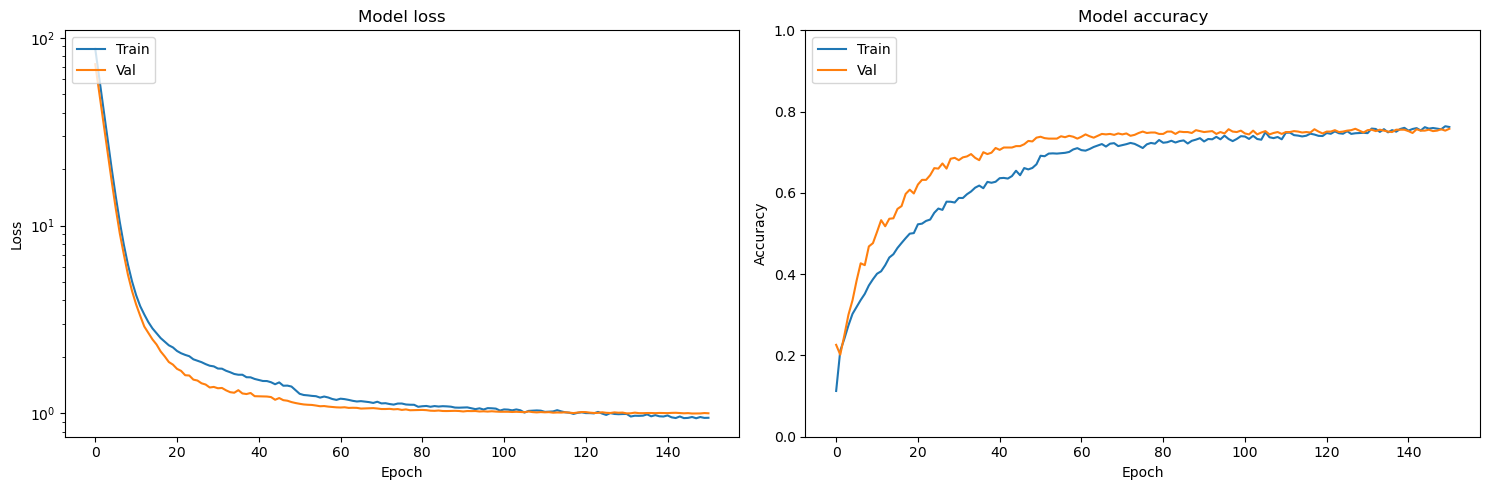

In [19]:
df_history_3 = pd.DataFrame(model.history.history)
df_history = pd.concat([df_history_1, df_history_2, df_history_3], ignore_index=True)

# Plot history
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df_history['loss'])
plt.plot(df_history['val_loss'])
plt.title('Model loss')
# logscale y
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(df_history['accuracy'])
plt.plot(df_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.ylim(0, 1)

plt.tight_layout()


In [24]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred))

217/217 [==============================] - 0s 952us/step
0.8630531930229206


In [21]:
model.evaluate(X_train, y_train)

217/217 [==============================] - 0s 1ms/step - loss: 0.5977 - accuracy: 0.8631


[0.5977180600166321, 0.8630532026290894]

In [22]:
model.evaluate(X_val, y_val)

28/28 [==============================] - 0s 3ms/step - loss: 1.0031 - accuracy: 0.7509


[1.0031074285507202, 0.7508650422096252]